In [1]:
from keras.models import load_model
import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imageio
import cv2
import dlib
import skimage
import skimage.measure
import skimage.transform
from skimage.transform import resize
plt.rcParams['figure.figsize'] = (15,15)
from tqdm import tqdm_notebook
#import torch
#import pyfrx as frx
from imutils import face_utils
import coremltools
import keras
from typing import List
import os
from skimage.color import rgb2hsv, hsv2rgb

Using TensorFlow backend.


In [2]:
# Get/Set part of the image from the in_selection region
def get_from_selection(in_frame, in_selection):
    return in_frame[in_selection[1]:in_selection[3], in_selection[0]:in_selection[2]]

def set_to_selection(in_frame, in_data, in_selection):
    in_frame[in_selection[1]:in_selection[3], in_selection[0]:in_selection[2]] = in_data
    return in_frame

# Wrap frame by the box of disired shape
def get_wrapped_frame(in_frame, shape_out, dtype=np.float32):
    if len(in_frame.shape) == 2:
        out_x_item = np.full(shape_out, 0, dtype=dtype)
    else:
#         print(shape_out[:2])
        out_x_item = np.full(shape_out[:2] + [in_frame.shape[-1],], 0, dtype=dtype)
    shape_in_array = np.array(in_frame.shape[:2]).astype(np.float32)
    shape_out_array = np.array(shape_out[:2]).astype(np.float32)
    new_shape = (shape_in_array / np.max(shape_in_array/shape_out_array)).astype(np.int)[:2]

    x_item_tmp = block_average_resize(in_frame, new_shape)
    r_begin = (shape_out_array - new_shape) // 2
    y_begin, x_begin = r_begin.astype(np.int)
    y_end, x_end = (r_begin + new_shape).astype(np.int)
    out_x_item[y_begin:y_end, x_begin:x_end] = x_item_tmp
    c_selection = (x_begin, y_begin, x_end, y_end)
    return out_x_item, c_selection

# Correct resize function
def block_average_resize(img_src, out_shape, dtype=np.float32):
    source_shape = np.array(img_src.shape)
    target_shape = np.array(out_shape[:2])

    if np.all(source_shape[:2] % target_shape[:2] == 0):
        stride_shape = tuple(source_shape[:2] // target_shape[:2])
        img_dst = img_src
    else:
        tmp_shape = (1 + (np.array(source_shape[:2]).astype(np.float32) / target_shape[:2]).astype(
            np.int)) * target_shape[:2]
        stride_shape = tuple((tmp_shape / target_shape[:2]).astype(np.int))
        img_dst = skimage.transform.resize(img_src, tmp_shape, preserve_range=True, mode='constant')

    if len(source_shape) == 3:
        stride_shape = stride_shape + (1,)
    img_out = skimage.measure.block_reduce(img_dst, stride_shape,
                                           np.average).astype(dtype)

    return img_out


def replace_frame_area(in_frame, in_data, area):
    in_frame[area[1]:area[3], area[0]:area[2]] = in_data

def replace_box_area(frame, boxed_frame, box_area, in_box_area):
    """
    Replaces frame area by boxed frame, artifacts of boxing (padding by zeroes) in boxed frame are excluded
    :param frame: image
    :param boxed_frame: image which will replace area of @frame
    :param box_area: coordinates of area in @frame where @boxed_frame will be placed
    :param in_box_area: coordinates of image data inside box (area without padding)
    """
    box_area_shape = (box_area[3] - box_area[1], box_area[2] - box_area[0])
    no_padding_boxed_frame = cut_frame_area(boxed_frame, in_box_area)
    original_box_rgb = resize_frame(no_padding_boxed_frame, box_area_shape)
    replace_frame_area(frame, original_box_rgb, box_area)

def set_to_selection(in_frame, in_data, in_selection):
    in_frame[in_selection[1]:in_selection[3], in_selection[0]:in_selection[2]] = in_data
    return in_frame

def cut_boxed_frame_area(frame, frame_area, box_shape=(128, 128)):
    """
    Cuts area from frame and fit it to box
    :param frame: image
    :param frame_area: coordinates of area for cutting (x_left, y_top, x_right, y_bottom)
    :param box_shape: size of box into which cutted area will be fitted: (width, height)
    :return:
        boxed_frame: frame area fitted to box
        in_box_area: area in box without padding
    """
    clipped_frame = cut_frame_area(frame, frame_area)
    boxed_frame, in_box_area = fit_frame_to_box(clipped_frame, box_shape)
    return boxed_frame, in_box_area

def get_frame_area_by_landmarks(frame_data_rgb, landmarks):
    # todo: move harcode of box_factor to settings
    top_left_point, bottom_right_point = calculate_landmarks_box_area(landmarks, box_factor=2.0)
    return max(top_left_point[0], 0), \
           max(top_left_point[1], 0), \
           min(bottom_right_point[0], frame_data_rgb.shape[1]), \
           min(bottom_right_point[1], frame_data_rgb.shape[0])


def calculate_landmarks_box_area(landmarks, box_factor=2.0, dtype=np.int):
    landmarks = np.array(landmarks)
    item_center = np.mean(landmarks.astype(np.float), 0)
    item_size = np.max(np.max(landmarks.astype(np.float), 0) - np.min(landmarks.astype(np.float), 0))
    top_left_x, top_left_y = (item_center - box_factor * item_size / 2.).astype(dtype)
    bottom_right_x, bottom_right_y = (item_center + box_factor * item_size / 2.).astype(dtype)
    return (top_left_x, top_left_y), (bottom_right_x, bottom_right_y)

def get_dlib_lanmarks(image):
    p = "../detectors/shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(p)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    # Get faces into webcam's image
    rects = detector(gray, 0)
    
    # For each detected face, find the landmark.
    for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
    return shape

def cut_boxed_frame_area(frame, frame_area, box_shape=(128, 128)):
    """
    Cuts area from frame and fit it to box
    :param frame: image
    :param frame_area: coordinates of area for cutting (x_left, y_top, x_right, y_bottom)
    :param box_shape: size of box into which cutted area will be fitted: (width, height)
    :return:
        boxed_frame: frame area fitted to box
        in_box_area: area in box without padding
    """
    clipped_frame = cut_frame_area(frame, frame_area)
    boxed_frame, in_box_area = fit_frame_to_box(clipped_frame, box_shape)
    return boxed_frame, in_box_area

def fit_frame_to_box(frame, box_shape):
    """Fits @in_frame to the @shape_out
    Stores frame proportions, padding free space by zeroes
    """
    shape_in_array = np.array(frame.shape[:2]).astype(np.float32)
    shape_out_array = np.array(box_shape[:2]).astype(np.float32)
    new_shape = (shape_in_array / np.max(shape_in_array / shape_out_array)).astype(np.int)[:2]

    fitted_frame = resize_frame(frame, new_shape)
    r_begin = (shape_out_array - new_shape) // 2
    y_begin, x_begin = r_begin.astype(np.int)
    y_end, x_end = (r_begin + new_shape).astype(np.int)

    target_shape = box_shape if frame.ndim == 2 else box_shape[:2] + (frame.shape[-1],)
    box_frame = np.full(target_shape, 0, dtype=frame.dtype)
    box_frame[y_begin:y_end, x_begin:x_end] = fitted_frame
    in_box_area = (x_begin, y_begin, x_end, y_end)

    return box_frame, in_box_area

def cut_frame_area(frame, area):
    return frame[area[1]:area[3], area[0]:area[2]]

def resize_frame(frame, target_shape, resize_func=np.average):
    source_shape = np.array(frame.shape)
    target_shape = np.array(target_shape[:2])

    if np.all(source_shape[:2] % target_shape[:2] == 0):
        stride_shape = tuple(source_shape[:2] // target_shape[:2])
        ready_frame = frame
    else:
        tmp_shape = (1 + (np.array(source_shape[:2]).astype(np.float32) / target_shape[:2])
                     .astype(np.int)) * target_shape[:2]
        stride_shape = tuple((tmp_shape / target_shape[:2]).astype(np.int))
        ready_frame = skimage.transform.resize(frame, tmp_shape, preserve_range=True, mode='constant')

    if len(source_shape) == 3:
        stride_shape = stride_shape + (1,)
    resized_frame = skimage.measure.block_reduce(ready_frame, stride_shape, resize_func).astype(frame.dtype)

    return resized_frame

def drawer(image, points, indeces_type, color=None, line_width=2):
    for coord, coord_next in zip(points[indeces_type], points[indeces_type[1:]]):
        image = cv2.line(np.array(image), tuple(coord), tuple(coord_next),
                         (255, 255, 255) if color is None else color,
                         line_width)
    return image

def get_sketch(shape, shapes_template_shape, color=True):
    DRAW_DICT = {'face':
                     {'points': list(range(0, 17)),
                      'color': (255, 0, 0)},
                 'braw_first':
                     {'points': list(range(17, 22)),
                      'color': (255, 127, 0)},
                 'braw_second':
                     {'points': list(range(22, 27)),
                      'color': (255, 255, 0)},
                 'nose':
                     {'points': list(range(27, 36)) + [30, ],
                      'color': (0, 255, 0)},
                 'eye_first':
                     {'points': list(range(36, 42)) + [36, ],
                      'color': (75, 0, 130)},
                 'eye_second':
                     {'points': list(range(42, 48)) + [42, ],
                      'color': (148, 0, 211)},
                 'lips':
                     {'points': list(range(48, 60)) + [48, ] + list(range(60, 65)) + [54, ] + list(
                         range(65, 68)) + [60, ],
                      'color': (0, 0, 255)}}
    shapes_template = np.full(shapes_template_shape, 0, dtype=np.uint8)
    shape = np.array(shape).astype(int)
    for key in DRAW_DICT:
        shapes_template = drawer(shapes_template, shape, DRAW_DICT[key]['points'],
                                      color=DRAW_DICT[key]['color'] if color else (255, 255, 255))
    return shapes_template

def get_skin_mask(in_frame_rgb, model, threshold=0.5):
    # This code just to predict skin mask
    x_item_raw = np.transpose(cv2.cvtColor(in_frame_rgb, cv2.COLOR_RGB2YUV), (1,0,2))
    input_shape = model.inputs[0].shape.as_list()
    input_shape[0] = 1
    x_item_in = np.full(input_shape, 0.0, dtype=np.float32)
    x_item_in[0, ..., :3], selection  = get_wrapped_frame(x_item_raw,  input_shape[1:3])
    x_item_in = x_item_in/255.
    for _ in range(7):
        x_item_in[...,-1] = model.predict(x_item_in)[0,...,0]
        x_item_in[...,-1] = model.predict(x_item_in)[0,...,0]
    model_prediction = model.predict(x_item_in)
    skin_mask = get_wrapped_frame(get_from_selection(model_prediction[0,...,0], selection), x_item_raw.shape[:2])[0]
    skin_mask = resize(np.transpose(skin_mask, (1, 0)), in_frame_rgb.shape[:2], preserve_range=True)
    return skin_mask, (skin_mask > threshold).astype(np.float)

def get_threshold_map(in_frame_rgb, block_size, offset):
    # Next we shoud get the 
    # the block size should be the function of faceboxsize
    # see more here https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
    exp_frame_gray_data = cv2.cvtColor(in_frame_rgb, cv2.COLOR_RGB2GRAY)
    exp_th_data = 255. - cv2.adaptiveThreshold(exp_frame_gray_data, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, offset)
    return exp_th_data/255.

def get_threshold_channel_map(in_frame_rgb, block_size, offset, channel):
    # Next we shoud get the 
    # the block size should be the function of faceboxsize
    # see more here https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
    exp_frame_gray_data = in_frame_rgb[..., channel]
    exp_th_data = 255. - cv2.adaptiveThreshold(exp_frame_gray_data, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, offset)
    return exp_th_data/255.

In [3]:
def find_max_rect(rects):
    return max(rects, key=lambda x: x.area())

def align_affine_opencv(src_frame, detector, predictor):
    
    gray = cv2.cvtColor(src_frame, cv2.COLOR_BGR2GRAY)
    
    # Get faces into webcam's image
    rects = detector(gray, 0)
    rect = find_max_rect(rects)
    
    # For each detected face, find the landmark.
#     for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    face_landmarks = shape
    
    cut_inpaint_box_shape = (512, 512)
    src_pts = np.float32([face_landmarks[36], face_landmarks[33], face_landmarks[45]])
#     print(src_pts)
    dst_pts_inpaint = 512*np.float32([[354, 520], [513*1090/1024, 691*1090/1024], [736, 520]])/1090.
    M_inpaint = cv2.getAffineTransform(src_pts, dst_pts_inpaint)
    iM_inpaint = cv2.getAffineTransform(dst_pts_inpaint, src_pts)
    
    dst_frame_inpaint = cv2.warpAffine(src_frame.copy(), M_inpaint, cut_inpaint_box_shape)
    return dst_frame_inpaint, M_inpaint, iM_inpaint

def align_opencv(src_frame, detector, predictor):    
    gray = cv2.cvtColor(src_frame, cv2.COLOR_BGR2GRAY)
    
    # Get faces into webcam's image
    rects = detector(gray, 0)
    rect = find_max_rect(rects)
    
    # For each detected face, find the landmark.
#     for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    face_landmarks = shape
    
    cut_inpaint_box_shape = (512, 512)
    src_pts = np.float32([face_landmarks[36], face_landmarks[45], face_landmarks[48], face_landmarks[54]])
#     print(src_pts)
    dst_pts_inpaint = 512*np.float32([[354, 520], [736, 520], [425, 805], [653, 805]])/1090.
    M_inpaint = cv2.getPerspectiveTransform(src_pts, dst_pts_inpaint)
    iM_inpaint = cv2.getPerspectiveTransform(dst_pts_inpaint, src_pts)
    
    dst_frame_inpaint = cv2.warpPerspective(src_frame.copy(), M_inpaint, cut_inpaint_box_shape)
    return dst_frame_inpaint, M_inpaint, iM_inpaint

def get_landmarks(src_frame, detector, predictor):
    gray = cv2.cvtColor(src_frame, cv2.COLOR_BGR2GRAY)
    
    # Get faces into webcam's image
    rects = detector(gray, 0)
    rect = find_max_rect(rects)
    
    # For each detected face, find the landmark.
#     for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    face_landmarks = shape
    return shape

In [4]:
p = "/Users/ekaterinaalenikova/Work/experiments/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)
plt.rcParams['figure.figsize'] = (15,15)

In [66]:
first_frame_path = '/Users/ekaterinaalenikova/Downloads/1042542259.jpeg_aligned.png'
first_frame_rgb = imageio.imread(first_frame_path)

second_frame_path = '/Users/ekaterinaalenikova/Downloads/1042542259.jpeg_aligned.png'
second_frame_rgb = imageio.imread(second_frame_path)[...,:3]

cat_frame_path = '/Users/ekaterinaalenikova/Downloads/bila-chlupaty-divani-259803.jpg'
cat_frame_rgb = imageio.imread(cat_frame_path)[...,:3]

In [67]:
img1 = first_frame_rgb.copy()
img2 = cv2.resize(second_frame_rgb.copy(),(1024*2,1024*2))
cat =cat_frame_rgb.copy()
img1Warped = np.copy(img2);    

In [68]:
points1 = get_landmarks(img1, detector, predictor)
points2 = get_landmarks(img2, detector, predictor)
points1 = [(x,y) for x,y in points1]
points2 = [(x,y) for x,y in points2]

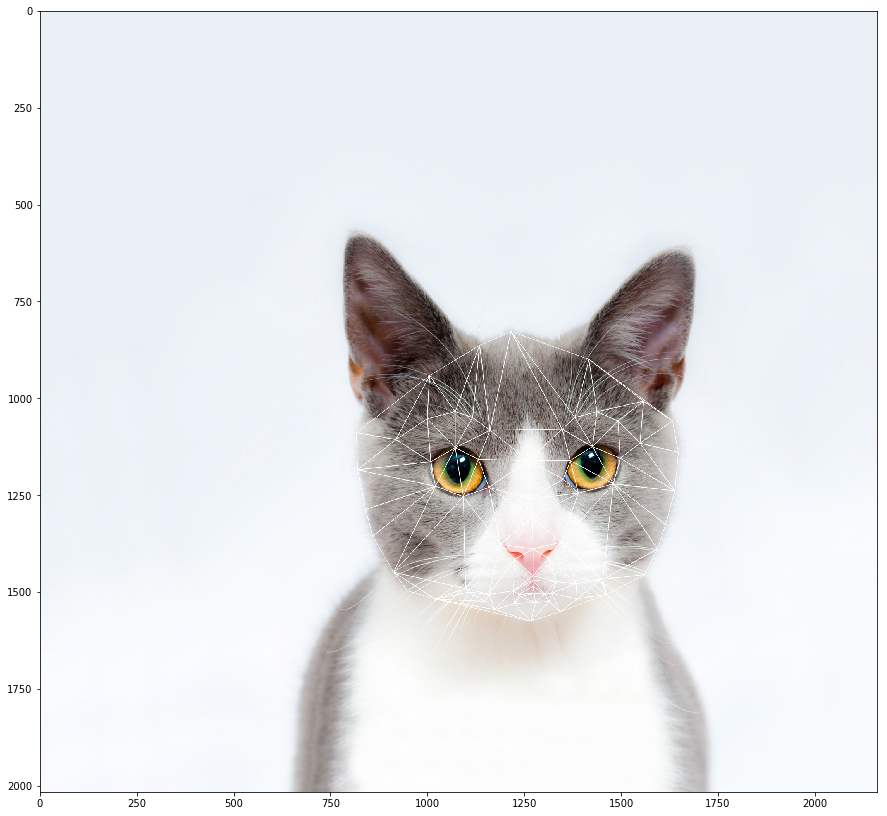

In [79]:
subdiv = cv2.Subdiv2D(rect);
for p in inp_p:
    subdiv.insert(p)
im=input_im.copy()
( facets, centers) = subdiv.getVoronoiFacetList([])
#print(facets)
draw_delaunay( im, subdiv, (255, 255, 255) );
plt.imshow(im)

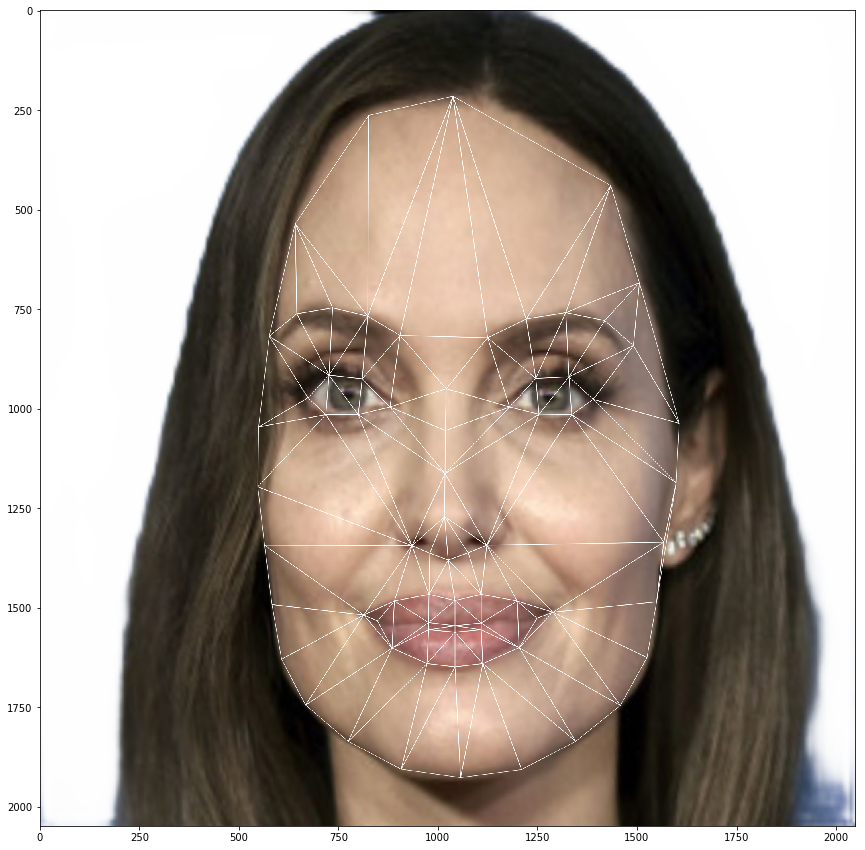

In [82]:
subdiv = cv2.Subdiv2D(rect);
for p in out_p:
    subdiv.insert(p)
im=output_im.copy()
( facets, centers) = subdiv.getVoronoiFacetList([])

draw_delaunay( im, subdiv, (255, 255, 255) );
plt.imshow(im)

In [55]:
import sys
import numpy as np
import cv2

# Read points from text file
def readPoints(path) :
    # Create an array of points.
    points = [];
    
    # Read points
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(x), int(y)))
    

    return points

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :

    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True


#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);

    # Insert points into subdiv
    for p in points:
        
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri
        

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :


    
    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

    
    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches

    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    
    size = (r2[2], r2[3])
    mask=cv2.resize(mask,size)

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    
    img2Rect = img2Rect * mask


    
    # Copy triangular region of the rectangular patch to the output image
    
    i = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

    

In [72]:
cat_points = points2.copy()

cat_points[0]=(816,1089)
cat_points[1]=(819,1185)
cat_points[2]=(840,1287)
cat_points[3]=(858,1356)
cat_points[4]=(912,1449)
cat_points[5]=(948,1497)
cat_points[6]=(1020,1518)
cat_points[7]=(1173,1545)
cat_points[8]=(1266,1575)

cat_points[9]=(1341,1551)
cat_points[10]=(1461,1506)
cat_points[11]=(1560,1455)
cat_points[12]=(1593,1389)
cat_points[13]=(1614,1326)
cat_points[14]=(1638,1239)
cat_points[15]=(1647,1140)
cat_points[16]=(1632,1059)

cat_points[17]=(918,1107)
cat_points[18]=(999,1053)
cat_points[19]=(1071,1035)
cat_points[20]=(1116,1050)
cat_points[21]=(1161,1083)
cat_points[22]=(1347,1080)
cat_points[23]=(1380,1050)
cat_points[24]=(1437,1035)
cat_points[25]=(1491,1059)
cat_points[26]=(1548,1116)

cat_points[27]=(1260,1161)
cat_points[28]=(1263,1260)
cat_points[29]=(1269,1308)
cat_points[30]=(1272,1389)

cat_points[31]=(1188,1377)
cat_points[32]=(1224,1416)
cat_points[33]=(1272,1458)
cat_points[34]=(1311,1413)
cat_points[35]=(1344,1371)

cat_points[36]=(1008,1164)
cat_points[37]=(1071,1128)
cat_points[38]=(1131,1158)
cat_points[39]=(1158,1230)
cat_points[40]=(1092,1254)
cat_points[41]=(1020,1227)

cat_points[42]=(1350,1209)
cat_points[43]=(1368,1161)
cat_points[44]=(1425,1125)
cat_points[45]=(1497,1155)
cat_points[46]=(1479,1221)
cat_points[47]=(1389,1245)

cat_points[48]=(1098,1491)
cat_points[49]=(1158,1506)
cat_points[50]=(1221,1497)
cat_points[51]=(1272,1470)
cat_points[52]=(1332,1473)
cat_points[53]=(1383,1479)
cat_points[54]=(1452,1467)

cat_points[55]=(1386,1518)
cat_points[56]=(1314,1524)
cat_points[57]=(1278,1527)
cat_points[58]=(1224,1530)
cat_points[59]=(1149,1524)
cat_points[60]=(1107,1500)

cat_points[61]=(1236,1506)
cat_points[62]=(1272,1485)
cat_points[63]=(1320,1503)

cat_points[64]=(1446,1467)

cat_points[65]=(1302,1506)
cat_points[66]=(1275,1503)
cat_points[67]=(1239,1512)


In [106]:
output_im=img2.copy()
out_p=points2.copy()
out_p.append((320*2,268*2))
out_p.append((412*2,132*2))
out_p.append((518*2,108*2))
out_p.append((716*2,220*2))
out_p.append((752*2,342*2))

input_im=cat_frame_rgb.copy()
inp_p=cat_points.copy()
inp_p.append((1005,942))
inp_p.append((1134,864))
inp_p.append((1215,828))
inp_p.append((1416,900))
inp_p.append((1557,1008))
imgWarped=output_im.copy()

In [111]:
input_im=img2.copy()
inp_p=points2.copy()
inp_p.append((320*2,268*2))
inp_p.append((412*2,132*2))
inp_p.append((518*2,108*2))
inp_p.append((716*2,220*2))
inp_p.append((752*2,342*2))

output_im=cat_frame_rgb.copy()
out_p=cat_points.copy()
out_p.append((1005,942))
out_p.append((1134,864))
out_p.append((1215,828))
out_p.append((1416,900))
out_p.append((1557,1008))

imgWarped=output_im.copy()

In [76]:
np.array(out_p).shape

(73, 2)

In [114]:
 # Find convex hull
hull1 = []
hull2 = []


hullIndex = cv2.convexHull(np.array(inp_p), returnPoints = False)

for i in range(0, len(hullIndex)):
    hull1.append(inp_p[int(hullIndex[i])])
    hull2.append(out_p[int(hullIndex[i])])


# Find output_im traingulation for convex hull points
sizeImg2 = output_im.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])



dt = calculateDelaunayTriangles(rect, inp_p)


if len(dt) == 0:
    quit()

num=[]
print(len(dt))
# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []
 
    #get points for img1, img2 corresponding to the triangles

        
    if dt[i][0]==28 and dt[i][1]==47 and dt[i][2]==29:
        dt[i]=(42,29,35)
        
    if dt[i][0]==29 and dt[i][1]==47 and dt[i][2]==15:
        dt[i]=(42,47,35)
        
    if dt[i][0]==14 and dt[i][1]==29 and dt[i][2]==15:
        dt[i]=(47,35,14)
        
    if dt[i][0]==29 and dt[i][1]==14 and dt[i][2]==30:
        dt[i]=(47,14,15)
        
    if dt[i][0]==30 and dt[i][1]==14 and dt[i][2]==35:
        dt[i]=(29,30,35)
        
    if dt[i][0]==14 and dt[i][1]==13 and dt[i][2]==35:
        dt[i]=(35,14,12)
        
    if dt[i][0]==13 and dt[i][1]==12 and dt[i][2]==35:
        dt[i]=(12,13,14)


        
    #for j in range(0, 3):
        #t1.append(inp_p[dt[i][j]])
        #t2.append(out_p[dt[i][j]])
        
    

    #warpTriangle(input_im, imgWarped, t1, t2)
    
#     if dt[i][0]<17 or dt[i][1]<17 or dt[i][2]<17 or (dt[i][0]>35 and dt[i][1]>35 and dt[i][2]>35 
#         and dt[i][0]<48 and dt[i][1]<48 and dt[i][2]<48) :
#         warpTriangle(input_im, imgWarped, t1, t2)
#     else: num.append(i)

s_pts= np.float32([inp_p[17], inp_p[26], inp_p[8]])
d_pts= np.float32([out_p[17], out_p[26], out_p[8]])
M_t = cv2.getAffineTransform(s_pts,d_pts)
inp_p0=np.expand_dims(np.concatenate([inp_p.copy(),np.expand_dims(np.ones(len(inp_p)),1)],-1),2)
transf_pig=np.transpose(np.dot(M_t,inp_p0))

transf_pig0=transf_pig[0]

#for i in range(len(transf_pig)):
#    transf_pig0.append((transf_pig[i][0][0],transf_pig[i][1][0]))
#transf_pig0=[(transf_pig[:,0,0],transf_pig[:,1,0])]

alpha = 0.95

inp_p2 = out_p.copy()
inp_p2[17:] = alpha*(np.array(transf_pig0)[17:]) + (1 - alpha) *(np.array(out_p).copy()[17:])
inp_p2= np.round(inp_p2)

for i in range(0, len(dt)):
    t1 = []
    t2 = []
    
    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
        t1.append(inp_p2[dt[i][j]])
        t2.append(inp_p[dt[i][j]])

    warpTriangle(input_im, imgWarped, t2, t1)


imgWarped

for i in range(0, len(dt)):
    
    t1 = []
    t2 = []
    
    for j in range(0, 3):
        t1.append(inp_p2[dt[i][j]])
        t2.append(out_p[dt[i][j]])
    
    if dt[i][0]>35 and dt[i][1]>35 and dt[i][2]>35 and dt[i][0]<48 and dt[i][1]<48 and dt[i][2]<48:
        warpTriangle(output_im, imgWarped, t2, t1)
        

# Calculate Mask
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(output_im.shape, dtype = output_im.dtype)  

cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

r = cv2.boundingRect(np.float32([hull2]))    

center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))

# Clone seamlessly.

output = cv2.seamlessClone(np.uint8(imgWarped), output_im, mask, center, cv2.NORMAL_CLONE)




122


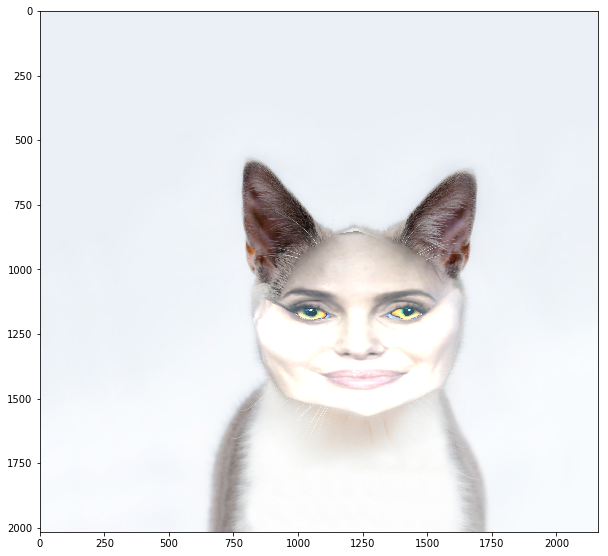

In [115]:
plt.imshow(output)
plt.show()

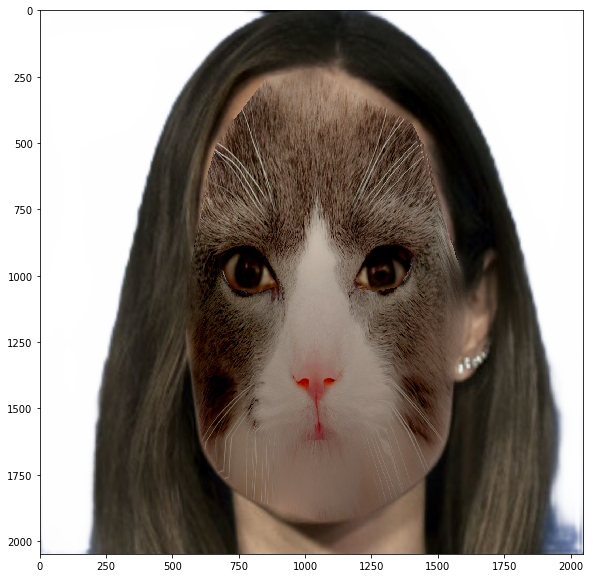

In [110]:
plt.imshow(output)
plt.show()

In [105]:
plt.rcParams['figure.figsize'] = (10,10)

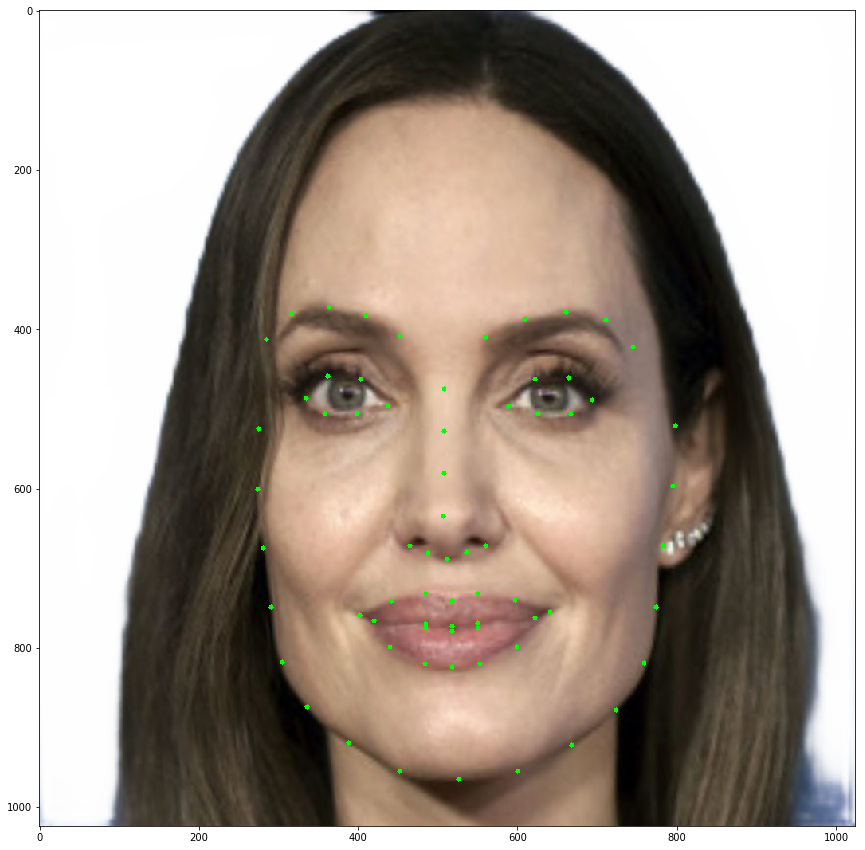

In [13]:
points4=points2.copy()

In [529]:
pig2.shape

(683, 1024, 3)

In [59]:
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True
 
# Draw a point
def draw_point(img, p, color ) :
    cv2.circle( img, p, 2, color, -1 )


 
 
# Draw delaunay triangles
def draw_delaunay(img, subdiv, delaunay_color ) :
 
    triangleList = subdiv.getTriangleList();
    size = img.shape
    r = (0, 0, size[1], size[0])
 
    for t in triangleList :
         
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
         
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
         
            cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)
 
 
# Draw voronoi diagram
def draw_voronoi(img, subdiv) :
 
    ( facets, centers) = subdiv.getVoronoiFacetList([])
 
    for i in range(0,len(facets)) :
        ifacet_arr = []
        for f in facets[i] :
            ifacet_arr.append(f)
         
        ifacet = np.array(ifacet_arr, np.int)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
 
        cv2.fillConvexPoly(img, ifacet, color, cv2.LINE_AA, 0);
        ifacets = np.array([ifacet])
        cv2.polylines(img, ifacets, True, (0, 0, 0), 1, cv2.LINE_AA, 0)
        cv2.circle(img, (centers[i][0], centers[i][1]), 3, (0, 0, 0), -1)

In [144]:
file1 = open("myfile.txt","w") 
for p in points1:
    file1.write(str(p[0])+","+str(p[1])+"\n")
file1.close()

In [145]:
file2 = open("myfile2.txt","w") 
for p in points2:
    file2.write(str(p[0])+","+str(p[1])+"\n")
file2.close()

In [156]:
def read_file(file_name):
    data=[]
    file = open(file_name,"r+") 
    data = file.readlines()
    data = [line.rstrip() for line in data]
    data = [line.split(",") for line in data]
    data = [(int(line[0]), int(line[1])) for line in data]
    file.close()
    return data

In [167]:
points11 = read_file("myfile.txt")
points22 = read_file("myfile2.txt")

image = img2
points = points22

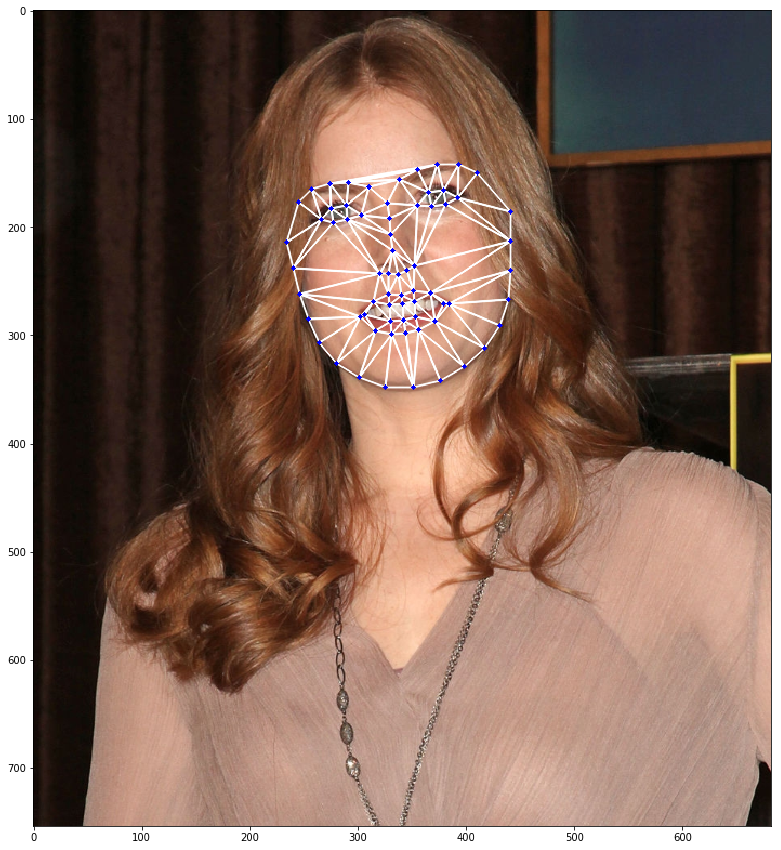

In [168]:
size = image.shape
rect = (0, 0, size[1], size[0])
     
# Create an instance of Subdiv2D
subdiv = cv2.Subdiv2D(rect);

for p in points:
    subdiv.insert(p)

draw_delaunay( image, subdiv, (255, 255, 255) );

for p in points:
    draw_point(image, p, (0,0,255))

# Allocate space for Voronoi Diagram
img_voronoi = np.zeros(image.shape, dtype = image.dtype)
 

plt.imshow(image)
plt.show()



In [44]:
img1.shape

(3088, 2320, 3)

In [62]:
import random

In [ ]:
second_frame_rgb_aligned.shape

In [ ]:
# show_item_idx = 4
# [show_item_idx:show_item_idx+10]

# writer = imageio.get_writer(f'../data_out/PigItAppMovie_2019.09.24.mov', fps=7)
for frame_index, frame_raw_source_path in tqdm_notebook(enumerate(list(sorted(bin_path_frame_list)))):
    #Read frames 
    frame_raw_source = np.fromfile(frame_raw_source_path, dtype=np.uint8).reshape((-1, 1280))
    frame_rgb = cv2.cvtColor(frame_raw_source, cv2.COLOR_YUV2RGB_NV12)
    frame_rgb = np.transpose(frame_rgb, (1,0,2))
    frame_yuv = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2YUV)
    frame_gray = frame_yuv[...,0].copy()
    
    #1. Original frame
    plt.imshow(frame_rgb)
    plt.show()
    
    frame_rgb_aligned, M, iM = align_opencv(frame_rgb, detector, predictor)

    #2. Make face aligment
    plt.imshow(frame_rgb_aligned)
    plt.show()
    
    #3. Select patch
    plt.imshow(patch_512x512[...,:3])
    plt.show()
    
    #4. HSV blending
    alpha = patch_512x512[...,-1]/255.
#     dst_frame_hsv = rgb2hsv(patch_512x512[...,:3])
#     src_frame_hsv = rgb2hsv(frame_rgb_aligned)
    
    dst_frame_hsv = cv2.cvtColor(patch_512x512[...,:3], cv2.COLOR_RGB2HSV)
    src_frame_hsv = cv2.cvtColor(frame_rgb_aligned, cv2.COLOR_RGB2HSV)
    
    out_frame_hsv = src_frame_hsv.copy()
#     out_frame_hsv[...,2] = ((dst_frame_hsv[...,2]**0.75)*alpha + src_frame_hsv[...,2]*(1.-alpha))
#     out_frame_hsv[...,1] = ((dst_frame_hsv[...,1]**(0.90))*alpha + src_frame_hsv[...,1]*(1.-alpha))
    out_frame_hsv[...,2] = ((dst_frame_hsv[...,2]**1)*alpha + src_frame_hsv[...,2]*(1.-alpha))
    out_frame_hsv[...,1] = ((dst_frame_hsv[...,1]**1)*alpha + src_frame_hsv[...,1]*(1.-alpha))
    # out_frame_hsv[...,0] = (((dst_frame_hsv[...,0] - 0.005)%1.)*alpha + src_frame_hsv[...,0]*(1.-alpha))%1.

#     out_frame_rgb = (hsv2rgb(out_frame_hsv)*255).astype(np.uint8)
    
    out_frame_rgb = cv2.cvtColor(out_frame_hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    
    boxed_frame_rgb_512_in = out_frame_rgb.copy()
    
    #5. HSV
    plt.imshow(out_frame_hsv)
    plt.show() 
    
    plt.imshow(out_frame_rgb)
    plt.show() 

    #6. Prepare inpaint
    sketch_in_data = 0*out_frame_rgb.copy()

    #fix overlight
    alpha = alpha #*((frame_rgb_aligned).mean(-1) > 250)
    fix_selection = ((alpha > 0.5)*255).astype(np.uint8)
    kernel = np.ones((5, 5),np.uint8)
    boxed_mask_sharp_512_fixed = cv2.dilate(fix_selection, kernel, iterations = 1) - cv2.erode(fix_selection, kernel, iterations = 1)
    selection_in = cv2.dilate(boxed_mask_sharp_512_fixed, kernel, iterations = 1)
    selection_in = cv2.dilate(selection_in, kernel, iterations = 1)
    mask_in_data = (np.tile(selection_in[..., None], (1, 1, 3)).astype(np.float32) > 0.01).astype(np.float32)

    boxed_frame_rgb_512_in[mask_in_data > 0.5] = 255

    x_in_data = np.concatenate([-1 + boxed_frame_rgb_512_in/127.5, 1. - mask_in_data, sketch_in_data/255.], -1)
    dbg_frame = (255*(((x_in_data[...,:3] + 1)/4.  + x_in_data[...,6:]/2))).astype(np.uint8)
    
    plt.imshow(dbg_frame)
    plt.show() 

    #7. Run inpaint model prediction
    y_out_data = inpaint_model.predict(np.transpose(x_in_data[None,...], (0, 3, 1, 2)))
    y_out_data = np.transpose(np.clip((y_out_data + 1)/2., 0., 1.), (0, 2, 3, 1))
    y_out_frame = (y_out_data[0]*255).astype(np.uint8)

    plt.imshow(y_out_frame)
    plt.show() 
    
    tmp_frame = cv2.warpPerspective(y_out_frame, iM, tuple(reversed(frame_rgb.shape[:2])))
    tmp_patch = cv2.warpPerspective(patch_512x512, iM, tuple(reversed(frame_rgb.shape[:2])), borderValue=0)
    tmp_patch = cv2.GaussianBlur(tmp_patch[...,3], (7, 7), 7)
    
    plt.imshow(tmp_patch)
    plt.show() 

    alpha_full = tmp_patch[...,None]/255.
    frame_rgb_out = (alpha_full*tmp_frame + (1. - alpha_full)*frame_rgb).astype(np.uint8)
    
    plt.imshow(tmp_frame)
    plt.show() 
    
    out_data_frame = np.hstack([frame_rgb, frame_rgb_out])
    plt.imshow(out_data_frame)
    plt.show()
    break
    
#     writer.append_data(out_data_frame)
    
# writer.close()

In [3]:
import tensorflow as tf
from keras import backend as K
import numpy as np

In [32]:
image1 = np.random.randint(0, 255,(2,128,128,3))
image2 = np.random.randint(0, 255,(2,128,128,3))

In [30]:
def tf_cov(x):
    mean_x = tf.reduce_mean(x, axis=[0,3], keep_dims=False)
    print(K.eval(mean_x).shape)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx

def calculate_fid_tf(act1, act2):
    sigma1 = tf_cov(act1)
    sigma2 = tf_cov(act2)
    mu1 = K.mean(act1,axis=[1,2])
    mu2 = K.mean(act2,axis=[1,2])
    # calculate sum squared difference between means
    ssdiff = K.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = tf.linalg.sqrtm(K.dot(sigma1,sigma2))
    # check and correct imaginary numbers from sqrt
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    loss = perceptual_loss0(act1, act2)
    return fid + loss

 

In [31]:
calculate_fid_tf(tf.cast(image1,'float'),tf.cast(image2,'float'))

(128, 128)


ValueError: Dimension 0 in both shapes must be equal, but are 3 and 1. Shapes are [3,128] and [1,128]. for 'MatMul_17' (op: 'BatchMatMul') with input shapes: [3,128,128,1], [1,128,128,3].